# **Music Recommendation System**

## **Problem Definition**

With the advent of technology, societies have become more efficient with their lives. At the same time, however, individual human lives have also become more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has in fact made it easier for humans with a shortage of time to find and consume good content.
Almost every internet-based company's revenue relies on the time consumers spend on its platform. These companies need to be able to figure out what kind of content is needed in order to increase customer time spent and make their experience better. Therefore, one of the key challenges for these companies is figuring out what kind of content their customers are most likely to consume.
Spotify is one such audio content provider with a huge market base across the world. With the ever-increasing volume of songs becoming available on the Internet, searching for songs of interest has become a tedious task in itself. However, Spotify has grown significantly in the market because of its ability to recommend the ‘best’ next song to each and every customer based on a huge preference database gathered over time - millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on users’ likes/dislikes. 

## **Objective**
To build a recommendation system to propose the top 10 songs for a user based on the likelihood of listening to those songs.

## **Data Dictionary**

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset. The first file contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

song_data

song_id - A unique id given to every song

title - Title of the song

Release - Name of the released album

Artist_name - Name of the artist 

year - Year of release

count_data

user _id - A unique id given to the user

song_id - A unique id given to the song

play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

### **Importing Libraries and the Dataset**

In [1]:
# # Mounting the drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Suppress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise.reader import Reader
from surprise.dataset import Dataset
from sklearn.preprocessing import LabelEncoder

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']

# Modeling
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering
import nltk
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.metrics import mean_squared_error
from surprise import accuracy

# Hyperparameters tuning
from surprise.model_selection import GridSearchCV

### **Load the dataset**

In [3]:
# # Importing the datasets
# count_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommendation Systems/Music Recommendation System/count_data.csv')
# song_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommendation Systems/Music Recommendation System/song_data.csv')

In [4]:
# Importing the datasets
count_df = pd.read_csv('count_data.csv')
song_df = pd.read_csv('song_data.csv')

In [5]:
count_df.head()

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [6]:
song_df.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


**Observations:**
- In count_df we see that the first Unnamed column are actually indices, we can drop them. 
- In song_df we see missing value in year column (0). There is likely other data missing so we need to adress it. 

In [7]:
count_df.drop('Unnamed: 0', axis=1, inplace=True)

### **Let's check the data types and and missing values of each column**

In [8]:
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   song_id     object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [9]:
(count_df['play_count'] <= 0).sum()

0

In [10]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


In [11]:
print((song_df['song_id'] == 0).sum())
print((song_df['title'] == 0).sum())
print((song_df['release'] == 0).sum())
print((song_df['artist_name'] == 0).sum())
print((song_df['year'] < 1700).sum())

0
0
0
0
484424


#### **Observations and Insights:**

- There are 3 columns and 2M rows  with no missing values in count_df. 
- There are 5 columns and 1M rows in song_df. Title and release have small fraction of missing values, while column year has almost 50% of missing values. 


In [12]:
# Let's merge the count_df and song_df data on "song_id" into one dataset
df = count_df.merge(song_df.drop_duplicates(keep='first'), 
                    on='song_id',
                    how='left')

In [13]:
# Applying label encoding for "user_id" and "song_id"
df[['user_id','song_id']] = df[['user_id','song_id']].apply(LabelEncoder().fit_transform)

In [14]:
df.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,736,1,Stronger,Graduation,Kanye West,2007
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [15]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of songs
ratings_count = dict()

for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [16]:
# We want our users to have listened at least 90 songs
RATINGS_CUTOFF = 90

# Create a list of users who need to be removed
remove_users = []

for user, num_ratings in ratings_count.items():
    
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [17]:
# Get the column containing the songs
songs = df.song_id

# Create a dictionary from songs to their number of users
ratings_count = dict()

for song in songs:
    # If we already have the song, just add 1 to their rating count
    if song in ratings_count:
        ratings_count[song] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[song] = 1    

In [18]:
# We want our song to be listened by at least 120 users to be considered
RATINGS_CUTOFF = 120

remove_songs = []

for song, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_songs.append(song)

df_final= df.loc[ ~ df.song_id.isin(remove_songs)]

In [19]:
df_final

,user_id,song_id,play_count,title,release,artist_name,year
206,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
208,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
209,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
210,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
211,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007
...,...,...,...,...,...,...,...
2054260,47786,9160,7,Sala De Recepção,O Mundo E Um Moinho,Cartola,1976
2054261,47786,9186,1,Bitter Sweet Symphony,Bitter Sweet Symphony,The Verve,1997
2054270,47786,9351,2,The Police And The Private,Live It Out,Metric,2005
2054280,47786,9543,1,Just Friends,Back To Black,Amy Winehouse,2006


## **Exploratory Data Analysis**

### **Let's check the total number of unique users, songs, artists in the data**

Total number of unique user id

In [20]:
df_final['user_id'].unique().shape

(3338,)

Total number of unique song id

In [21]:
df_final['song_id'].unique().shape

(620,)

Total number of unique artists

In [22]:
df_final['artist_name'].unique().shape

(247,)

#### **Observations and Insights:**

- We have 3338 unique users, 620 unique songs and 247 unique artists.


### **Let's find out about the most interacted songs and interacted users**

Most interacted songs

In [23]:
df_final.groupby('song_id').count()['user_id'].sort_values(ascending=False)

song_id
8582    1792
6293    1384
3567    1086
352     1075
4270    1020
        ... 
7802     121
3558     121
2796     120
235      120
8282     120
Name: user_id, Length: 620, dtype: int64

Most interacted users

In [24]:
df_final.groupby('user_id').count()['song_id'].sort_values(ascending=False)

user_id
61472    287
15733    256
3237     253
37049    252
43041    226
        ... 
11980      2
76347      2
56789      1
45476      1
19776      1
Name: song_id, Length: 3338, dtype: int64

#### **Observations and Insights:**

- The song_id 8585 is the most interacted with, having 1792 interactions. The least amount of interactions is 120 according to the cut-off we set earlier. 
- The user_id 61472 have the most interactions with the songs, having 287 interactions. The least amount of interactions is 1. This is different from initial cut-off of 90 set because we have filtered a lot of songs after with threshold 120. 


Songs played by a year

In [25]:
count_songs = df_final.groupby('year').count()['title']

count = pd.DataFrame(count_songs)

count.drop(count.index[0], inplace = True)

count.sort_values(by='title', ascending=False).head()

,title
year,
2009,20377
2008,18099
2007,16650
2003,10432
2006,9712


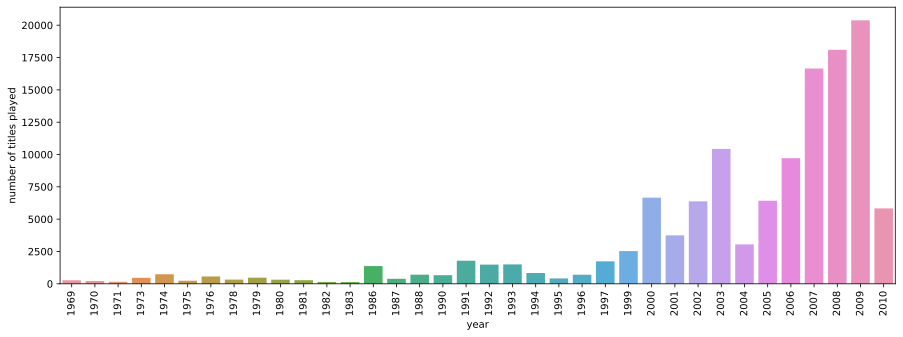

In [26]:
# Let's plot the data above
plt.figure(figsize = (15, 5))

sns.barplot(x = count.index,
            y = 'title',
            data = count,
            estimator = np.median)

plt.xticks(rotation=90)
# Set the y label of the plot
plt.ylabel('number of titles played') 

# Show the plot
plt.show()

#### **Observations and Insights:** #

- The most popular songs are from the recent years. With the songs from 2009 being the most popular. 
- Old songs from 1969 to 1999 are not that popular and are not that often interacted with.  

## **Proposed approach**
**Potential techniques:**

Let's explore different recommender system techiques starting from simple such as KNNBasic and up to the advanced hybrid recommender systems.<br>

**Measures of success:** 

As the measure of success we will use RMSE, Precision, Recall and F1 Score. The major success measure would be F1 Score as it universally measures the model perfomance.<br>

# **Music Recommendation System**

Now that we have explored the data, let's apply different algorithms to build recommendation systems.

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [27]:
# Calculating average play_count
average_count = df_final.groupby('song_id').mean()['play_count']

# Calculating the frequency a song is played
play_freq = df_final.groupby('song_id').count()['play_count']

In [28]:
# Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count':average_count, 'play_freq':play_freq})

# Let us see the first five records of the final_play dataset
final_play.head()

,avg_count,play_freq
song_id,,
21,2.157534,292
22,1.751724,145
50,3.032787,122
52,2.281893,486
62,2.604478,134


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [29]:
def top_n_songs(data, n, min_interactions=100):
    
    # Finding songs with minimum number of interactions
    recommendations = data[data['play_freq'] > min_interactions]
    
    # Sorting values w.r.t. average rating 
    recommendations = recommendations.sort_values('avg_count', ascending=False)

    return recommendations.index[:n]

In [30]:
# Let's recommend top 10 songs using the function defined above
top_n_songs(final_play, 10, min_interactions=100).values

array([ 614,  317, 8324, 6450, 4545, 7913, 1664, 6246, 5653, 4864])

### **User User Similarity-Based Collaborative Filtering**

Let's build a function to calculate precision@k and recall@k, RMSE and F1_Score@k to evaluate the model performance.

In [31]:
def precision_recall_at_k(model, k=30, threshold=2):
    """Return precision and recall at k metrics for each user"""

    # Map the predictions to each user.
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

In [32]:
# Instantiating Reader scale with expected rating scale 
reader = Reader(rating_scale=(0,5))

# Loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.4, random_state = 42)

In [33]:
# Build the default user-user-similarity model
sim_options = {'name': 'cosine',
               'user_based':True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let's compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(sim_user_user)

RMSE: 4.8306
Precision:  0.467
Recall:  0.637
F_1 score:  0.539


**Observations and Insights:**

- We got mediocre results.
- The Precision and Recall are very imbalanced. 

In [34]:
# Predicting play_count for a sample user with a listened song
sim_user_user.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 2.02   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=2.024433937053987, details={'actual_k': 40, 'was_impossible': False})

In [35]:
# Predicting play_count for a sample user with a song not-listened by the user
sim_user_user.predict(6958, 3232, verbose = True) 

user: 6958       item: 3232       r_ui = None   est = 2.34   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=2.3360024611479173, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**

- We see that on a random sample chosen it shows quite resonable result.

Now, let's try to tune the model and see if we can improve the model performance.

In [37]:
import time

In [38]:
# The start time
st = time.time()

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40, 50],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ["msd", "cosine", 'pearson', "pearson_baseline"],
              'user_based': [True],
               "min_support": [2, 4]}
              }

gs_user = GridSearchCV(KNNBasic,
                  param_grid, 
                  measures=['rmse'],
                  cv=3,
                  n_jobs=-1) 

# Fitting the data
gs_user.fit(data)

# Best RMSE score
print(gs_user.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_user.best_params['rmse'])

# The end time
et = time.time()

# The execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

4.669347487382129
{'k': 50, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}
Execution time: 941.1592061519623 seconds


In [47]:
# Let's train the best model found in above gridsearch
sim_options = {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}
sim_user_user_optimized = KNNBasic(k=50, min_k=9,sim_options=sim_options)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user_optimized.fit(trainset)

# Let's compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(sim_user_user_optimized)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 4.7444
Precision:  0.509
Recall:  0.636
F_1 score:  0.565


**Observations and Insights:**

- We managed to improve the performance, but it still not very good. 
- The precision and recall are still imbalanced. 

**Let's create an implementing function where the input parameters are:**

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [56]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'song_id', values = 'play_count')
    
    # Extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x : x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [62]:
# Let's make top 5 recommendations for user_id 6958
# with a user similarity-based recommendation engine
recommendations =get_recommendations(df_final, 6958, 5, sim_user_user_optimized)

In [63]:
# Building the dataframe for above recommendations.
pd.DataFrame(recommendations,columns=["song_id","predicted_rating"])

,song_id,predicted_rating
0,317,5
1,614,5
2,1739,5
3,2796,5
4,5653,5


### Correcting the play_counts and Ranking the above songs

While comparing the ratings of two songs, it is not only the **rating** that describe the **likelihood of the user to that song**. Along with the rating, the **number of users who have listened to that song** is also very important to consider. Due to this let's calculate the **"corrected_ratings"** for each song. 

Commonly the higher the **"play frequency" of a song the more it is liked by the users**. To interpret the above concept, a **song rated 4 with a play frequency of 120 is less liked in comparison to a song rated 3 with a play frequency of 600**. It has been **empirically found that the likelihood of the item can be corrected by adding or subtracting the inverse of the square root of the rating_count of the product (based on ideas from Central Limit Theorem)**.

In [75]:
def ranking_songs(recommendations, final_rating):
  # Sort the songs based on play counts
  ranked_songs = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending = False)[['play_freq']].reset_index()

  # Merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations,
                                     columns = ['song_id', 'predicted_rating']),
                                     on = 'song_id', 
                                     how = 'inner')

  # Rank the songs based on corrected play_counts
  ranked_songs['corrected_ratings'] = ranked_songs['predicted_rating'] - 1 / np.sqrt(ranked_songs['play_freq'])

  # Sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending = False)
  
  return ranked_songs

We could have add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions** and recommend songs with high predicted rating even if they haven't been listened by many users prior to that and thus favor new songs. But let's stick to the more strict recommender engine for now. 

In [76]:
# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_rating,corrected_ratings
0,317,727,5,4.962912
1,614,666,5,4.961251
2,1739,279,5,4.940132
3,5653,165,5,4.922150
4,2796,120,5,4.908713


**Observations and Insights:**

We see that the ratings were corrected according to the play frequency. 

### Item Item Similarity-based collaborative filtering recommendation systems 

In [39]:
sim_options = {'name': 'cosine',
               'user_based':False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_item_item.fit(trainset)

# Let's compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(sim_item_item)

RMSE: 4.7295
Precision:  0.333
Recall:  0.497
F_1 score:  0.399


**Observations and Insights:**

- Item-Item filtering gives us much worse results then user-user filtering. 
- The precision and recall are still very imbalanced. 

In [40]:
# The start time
st = time.time()

# Let's apply grid search for enhancing model performance

param_grid = {'k': [10, 20, 30, 40, 50],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ["msd", "cosine", 'pearson', "pearson_baseline"],
              'user_based': [False],
               "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs_item = GridSearchCV(KNNBasic,param_grid, measures=['rmse'],cv=3,n_jobs=-1) 

# Fitting the data
gs_item.fit(data)

# Best RMSE score
print(gs_item.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_item.best_params['rmse'])

# The end time
et = time.time()

# The execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

4.613152141484664
{'k': 50, 'min_k': 3, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}
Execution time: 290.4352819919586 seconds


In [80]:
# Let's train the best model found in the grid search
sim_options = {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}
sim_item_item_optimized = KNNBasic(k=50, min_k=3, sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_item_item_optimized.fit(trainset)

# Let's compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(sim_item_item_optimized)

RMSE: 4.6847
Precision:  0.463
Recall:  0.516
F_1 score:  0.488


**Observations and Insights:**

- We improved the performance of the baseline algorithm, but it's still inferior to the user-user model. 
- The precision and recall look quite balanced. 

In [82]:
# Making top 5 recommendations for user_id 6958 with item_item_similarity-based recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, sim_item_item_optimized)

In [83]:
# Building the dataframe for the above recommendations
pd.DataFrame(recommendations,columns=["song_id","predicted_rating"])

,song_id,predicted_rating
0,210,2.659516
1,1696,2.659516
2,2098,2.659516
3,2500,2.659516
4,3465,2.659516


In [84]:
# Applying the ranking_songs function
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_rating,corrected_ratings
0,2098,196,2.659516,2.588088
1,2500,187,2.659516,2.586389
2,3465,140,2.659516,2.575001
3,1696,123,2.659516,2.569349
4,210,122,2.659516,2.568981


**Observations and Insights:**

- We see that the item-item filtering algorithm recommends very different set of songs to that that was recommended by user-user algorithm.
- The predicted rating for the recommnded songs is much lower compared to the predicted rating of the songs recommended by user-user approach. 

### Model Based Collaborative Filtering - Matrix Factorization

Let's try Model-based Collaborative Filtering. 

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We will use **latent features** to find recommendations for each user.

In [41]:
svd = SVD(random_state=1)
svd.fit(trainset)
precision_recall_at_k(svd)

RMSE: 4.7257
Precision:  0.502
Recall:  0.591
F_1 score:  0.543


#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [42]:
# The start time
st = time.time()

# Let's set the parameter space to tune
param_grid ={'n_factors' : [80,90,100,120,140,160,180,200],
              'biased' : [True,False],
              'n_epochs': [10,20,30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performe 3-fold grid-search cross-validation
gs_svd = GridSearchCV(SVD,param_grid, measures=['rmse'],cv=3,n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

# The end time
et = time.time()

# The execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

4.61063054522502
{'n_factors': 200, 'biased': True, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}
Execution time: 525.8611788749695 seconds


In [85]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_factors=200, 
                    biased=True,
                    n_epochs=10,
                    lr_all=0.005,
                    reg_all=0.2,
                    random_state=1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Let's compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(svd_optimized)

RMSE: 4.6821
Precision:  0.488
Recall:  0.642
F_1 score:  0.555


**Observations and Insights:**

- We got slightly worse results that were achieved by the best approach so far - optimized user-user collaborative filtering. 

In [86]:
# Making top 5 recommendations for user_id 6958 with personal clustering recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, svd_optimized)

In [87]:
# Building the dataframe for the above recommendations
pd.DataFrame(recommendations,columns=["song_id","predicted_rating"])

,song_id,predicted_rating
0,614,4.675920
1,6450,4.496411
2,5653,4.486393
3,8801,4.458413
4,8324,4.408456


In [88]:
# Applying the ranking_songs function to correct predictions
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_rating,corrected_ratings
0,614,666,4.675920,4.637171
1,6450,180,4.496411,4.421875
2,5653,165,4.486393,4.408543
4,8801,121,4.458413,4.367504
3,8324,163,4.408456,4.330130


**Observations and Insights:**

- We got a very different set of recommendations compared to the one that was provided by user-user approach. 
- Only two songs are the same - 614 and 5653. 
- None of the songs match recommendations provided by item-item approach. 

### Cluster Based Recommendation System

Let's try a Cluster Based Recommendation System. 

In **clustering-based recommendation systems**, we will explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We will cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [43]:
# Using CoClustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

# Let's compute precision@k, recall@k, and F_1 score with k = 30
precision_recall_at_k(clust_baseline)

RMSE: 4.7047
Precision:  0.443
Recall:  0.509
F_1 score:  0.474


#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [44]:
# The start time
st = time.time()

# Setting the parameter space to tune
param_grid = {'n_cltr_u': [5, 6, 7, 8],
              'n_cltr_i': [5, 6, 7, 8],
              'n_epochs': [10, 20, 30]}

# Performing 3-fold grid search cross-validation
gs_clust = GridSearchCV(CoClustering, 
                        param_grid=param_grid,
                        measures=['rmse'],
                        cv=3,
                        n_jobs=-1)

# Fitting data
gs_clust.fit(data)

# Best RMSE score
print(gs_clust.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_clust.best_params['rmse'])

# The end time
et = time.time()

# The execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

4.639406696640225
{'n_cltr_u': 5, 'n_cltr_i': 6, 'n_epochs': 30}
Execution time: 94.26054096221924 seconds


In [89]:
# Train the tuned Coclustering algorithm
clust_optimized = CoClustering(n_cltr_u=5, n_cltr_i=6, n_epochs=30, random_state=1)

# Training the algorithm on the train set
clust_optimized.fit(trainset)

# Let's compute precision@k, recall@k, and F_1 score with k = 30
precision_recall_at_k(clust_optimized)

RMSE: 4.7108
Precision:  0.44
Recall:  0.495
F_1 score:  0.466


**Observations and Insights:**

- Unfortunately this approach still shows very poor results and we didn't manage to improve its performance. 

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [90]:
# Making top 5 recommendations for user_id 6958 with personal clustering recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, clust_optimized)

In [91]:
# Building the dataframe for the above recommendations
pd.DataFrame(recommendations,columns=["song_id","predicted_rating"])

,song_id,predicted_rating
0,317,5.000000
1,614,5.000000
2,4545,5.000000
3,8324,5.000000
4,5653,4.836545


### Correcting the play_count and Ranking the above songs

In [92]:
# Applying the ranking_songs function to correct predictions
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_rating,corrected_ratings
0,317,727,5.000000,4.962912
1,614,666,5.000000,4.961251
3,8324,163,5.000000,4.921674
4,4545,136,5.000000,4.914251
2,5653,165,4.836545,4.758695


**Observations and Insights:**

- Despite poor results, this approach provided the closest list of recommended song to the user-user approach which is  best performing algorithm so far. 
- 3 Songs match user-user recommendation list: 317, 614 and 5653. 

### Content Based Recommendation Systems

So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Let's take song features into account.


In [104]:
df_small = df_final

In [105]:
df_small['text'] = df_small['title'] + ' ' + df_small['release'] + ' ' + df_small['artist_name']
df_small.head()

,user_id,song_id,play_count,title,release,artist_name,year,text
206,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,Daisy And Prudence Distillation Erin McKeown
208,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,The Ballad of Michael Valentine Sawdust The Ki...
209,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,I Stand Corrected (Album) Vampire Weekend Vamp...
210,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007,They Might Follow You Tiny Vipers Tiny Vipers
211,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007,Monkey Man You Know I'm No Good Amy Winehouse


In [106]:
# Let's select the relevant columns
df_small = df_small[['user_id', 'song_id', 'play_count', 'title', 'text']]
df_small = df_small.drop_duplicates(subset = ['title'])
df_small = df_small.set_index('title')

df_small.head()

,user_id,song_id,play_count,text
title,,,,
Daisy And Prudence,6958,447,1,Daisy And Prudence Distillation Erin McKeown
The Ballad of Michael Valentine,6958,512,1,The Ballad of Michael Valentine Sawdust The Ki...
I Stand Corrected (Album),6958,549,1,I Stand Corrected (Album) Vampire Weekend Vamp...
They Might Follow You,6958,703,1,They Might Follow You Tiny Vipers Tiny Vipers
Monkey Man,6958,719,1,Monkey Man You Know I'm No Good Amy Winehouse


In [111]:
# Download punkt library
nltk.download("punkt")

# Download stopwords library
nltk.download("stopwords")

# Download wordnet 
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antonspivak/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antonspivak/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antonspivak/nltk_data...


True

Let's create a **function to pre-process the text data.**

The terminology used:
- **stopwords:** A stop word is a commonly used word (such as “the”, “a”, “an”, or “in”) that does not contain information in the text and can be ignored.
- **Lemmatization:** Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analyzed as a single item. For example, runs, running, and ran are all forms of the word run, therefore run is the lemma of all these words.

In [112]:
# Function to tokenize the text
def tokenize(text):
    
    text = re.sub(r"[^a-zA-Z]"," ", text.lower())
    
    tokens = word_tokenize(text)
    
    words = [word for word in tokens if word not in stopwords.words("english")]
    
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [113]:
# tfidf vectorizer 
tfidf = TfidfVectorizer(tokenizer = tokenize)
song_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()

In [114]:
# Making the DataFrame of song_tfidf data
pd.DataFrame(song_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [115]:
# Calculating the cosine similarity
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

# Let's see the above array
similar_songs

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.03257364],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.03257364, ..., 0.        , 0.        ,
        1.        ]])

 Finally, let's create a function to find most similar songs to recommend for a given song.

In [122]:
# Function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):
    
    recommended_songs = []
    
    indices = pd.Series(df_small.index)
    
    # Getting the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # Getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1 : 11].index)
    print(top_10_indexes)
    
    # Populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df_small.index)[i])
        
    return recommended_songs

Recommending 10 songs similar to Learn to Fly

In [123]:
# Make the recommendation for the song with title 'Learn To Fly'
recommendations('Learn To Fly', similar_songs)

[472, 544, 285, 490, 395, 455, 420, 413, 414, 415]


['Big Me',
 'Everlong',
 'The Pretender',
 'Nothing Better (Album)',
 'From Left To Right',
 'Lifespan Of A Fly',
 'Did It Again (featuring Kid Cudi)',
 "I'm Still Breathing",
 'Stronger',
 'Already Gone']

**Observations and Insights:**
- The recommended songs belong to the same or close genres to the Learn To Fly which is hard rock. 

## **Conclusion and Recommendations:** 


- The best performance was achieved with optimised KNNBasic model based on user-user similarities, F1 Score = 56.5%
- Matrix Factorization has lower RMSE with SVD approach (4.68 vs 4.74) because this method assumes that both products and users are present in some low dimensional latent space describing their properties and recommends a product based on its proximity to the user in the latent space.
- We recommend to use optimised KNNBasic model at this stage as it gives the best results. 


## **Next Steps**:
We propose to:

 -  Consider hybrid recommendation system as it has potential to push the performance even further.  